In [1]:
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn import preprocessing


/Users/alpha/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Stereo Image Depth Map
### Trying this method first, doesn't work as well as 2 CSVs

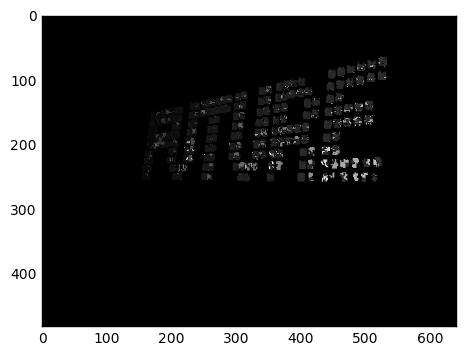

In [2]:
# Use CV Stereo depth mapping
# Input -> 2 regular images (Left, Right)
imgL = cv2.imread('future_binary_eye_dist_L.png',0)
imgR = cv2.imread('future_binary_eye_dist_R.png',0)

stereo = cv2.StereoBM_create(numDisparities=32, blockSize=5)
disparity = stereo.compute(imgL,imgR)
plt.imshow(disparity,'gray')
plt.show()

# Load left + right CSV files
### - Merge the files
### - Create Z coordinate using distance between XY coordinates of each file
### Greater Z value indicates that the LED is closer to the camera

In [70]:
# Load left + right CSV files
# Get the point distance to create z vector
dfL = pd.read_csv("future_L.csv")
dfR = pd.read_csv("future_R.csv")
dfL.rename(columns={"x":"lx", "y":"ly"}, inplace=True)
dfR.rename(columns={"x":"rx", "y":"ry"}, inplace=True)

# Combine the dataframes
df = pd.merge(dfL, dfR)
df.to_csv("testOutputNotNormalized.csv")

In [71]:
def getDistance(data):
#     a = s['path'] + 2*s['row'] # Simple calc for example
    a = np.array((data.lx, data.ly))
    b = np.array((data.rx, data.ry))
    dist = np.linalg.norm(a-b)
    
    return pd.Series(dict(z=dist))

In [72]:
df.z = df.apply(getDistance, axis=1)

In [23]:
df.to_csv("testOutputNotNormalizedIncludingZ.csv")

In [54]:
df.tail()

,address,lx,ly,z,rx,ry
235,235,482.0,151.5,40.078049,442.0,149.0
236,236,480.0,171.5,40.112342,440.0,168.5
237,237,477.5,191.5,40.078049,437.5,189.0
238,238,475.5,211.5,40.549353,435.0,209.5
239,239,473.5,232.5,40.610959,433.0,229.5


In [73]:
# Normalize entire data frame
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
ndf = pd.DataFrame(x_scaled, columns=["address", "x", "y", "z", "discardX", "discardY"])

In [56]:
# At this point, the address has been 'normalized' as well. 
# We don't want that
ndf

,address,x,y,z,discardX,discardY
0,0.000000,0.184654,0.992095,0.566052,0.151818,0.992032
1,0.004184,0.173693,0.994071,0.566052,0.140000,0.994024
2,0.008368,0.177909,0.944664,0.566052,0.144545,0.944223
3,0.012552,0.182125,0.899209,0.566988,0.149091,0.896414
4,0.016736,0.186341,0.853755,0.556185,0.154545,0.850598
5,0.020921,0.190556,0.806324,0.566988,0.158182,0.802789
6,0.025105,0.194772,0.758893,0.556185,0.163636,0.754980
7,0.029289,0.198145,0.715415,0.545384,0.168182,0.711155
8,0.033473,0.202361,0.667984,0.545384,0.172727,0.663347
9,0.037657,0.206577,0.624506,0.557348,0.176364,0.617530


In [74]:
# Discard extra x, y coord (from Right channel CSV)
ndf = ndf[["address", "x", "y", "z"]]



In [75]:
# Reset the addresses to integers (not normalized)
ndf.address = df.address

In [61]:
ndf.tail()

,address,x,y,z
235,235,0.812816,0.598814,0.869978
236,236,0.809444,0.677866,0.870722
237,237,0.805228,0.756917,0.869978
238,238,0.801855,0.835968,0.880209
239,239,0.798482,0.918972,0.881546


In [68]:
# Filter out zero values
ndf = ndf[ndf.x+ndf.y+ndf.z > 0.0]
print ndf

     address         x         y         z
0          0  0.184654  0.992095  0.566052
1          1  0.173693  0.994071  0.566052
2          2  0.177909  0.944664  0.566052
3          3  0.182125  0.899209  0.566988
4          4  0.186341  0.853755  0.556185
5          5  0.190556  0.806324  0.566988
6          6  0.194772  0.758893  0.556185
7          7  0.198145  0.715415  0.545384
8          8  0.202361  0.667984  0.545384
9          9  0.206577  0.624506  0.557348
10        10  0.218381  0.618577  0.556185
11        11  0.230185  0.614625  0.568129
12        12  0.241990  0.608696  0.566988
13        13  0.253794  0.604743  0.566988
14        14  0.266442  0.600791  0.568129
15        15  0.262226  0.648221  0.578912
16        16  0.250422  0.652174  0.577792
17        17  0.237774  0.656126  0.566988
18        18  0.225970  0.660079  0.566988
19        19  0.214165  0.664032  0.556185
20        20  0.209949  0.711462  0.556185
21        21  0.205734  0.756917  0.555231
22        2

In [76]:
# Export normalized CSV
ndf.to_csv("future_stereo_with_zeros.csv", index=False)

In [30]:
ndf

,address,lx,ly,z,rx,ry
0,0,109.5,251.0,26.076810,83.5,249.0
1,1,103.0,251.5,26.076810,77.0,249.5
2,2,105.5,239.0,26.076810,79.5,237.0
3,3,108.0,227.5,26.119916,82.0,225.0
4,4,110.5,216.0,25.622256,85.0,213.5
5,5,113.0,204.0,26.119916,87.0,201.5
6,6,115.5,192.0,25.622256,90.0,189.5
7,7,117.5,181.0,25.124689,92.5,178.5
8,8,120.0,169.0,25.124689,95.0,166.5
9,9,122.5,158.0,25.675864,97.0,155.0
